In [1]:
import re
import glob 

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
num_hidden_nodes = [16, 32]
activations = 2*['tanh']
num_atoms = 32

In [3]:
def my_loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=0)

In [4]:
X_train_paths = pd.read_parquet('X_'+'paths'+'_train.parquet')
X_dev_paths = pd.read_parquet('X_'+'paths'+'_dev.parquet')
X_test_paths = pd.read_parquet('X_'+'paths'+'_test.parquet')

scaler = MinMaxScaler().fit(X_train_paths)
    
X_train_paths = pd.DataFrame(scaler.transform(
    X_train_paths), columns=X_train_paths.columns, index=X_train_paths.index)
X_dev_paths = pd.DataFrame(scaler.transform(
    X_dev_paths), columns=X_dev_paths.columns, index=X_dev_paths.index)
X_test_paths = pd.DataFrame(scaler.transform(
    X_test_paths), columns=X_test_paths.columns, index=X_test_paths.index)

In [5]:
X_train_cycles = pd.read_parquet('X_'+'cycles'+'_train.parquet')
X_dev_cycles = pd.read_parquet('X_'+'cycles'+'_dev.parquet')
X_test_cycles = pd.read_parquet('X_'+'cycles'+'_test.parquet')

scaler = MinMaxScaler().fit(X_train_cycles)
    
X_train_cycles = pd.DataFrame(scaler.transform(
    X_train_cycles), columns=X_train_cycles.columns, index=X_train_cycles.index)
X_dev_cycles = pd.DataFrame(scaler.transform(
    X_dev_cycles), columns=X_dev_cycles.columns, index=X_dev_cycles.index)
X_test_cycles = pd.DataFrame(scaler.transform(
    X_test_cycles), columns=X_test_cycles.columns, index=X_test_cycles.index)

In [6]:
f_train = pd.read_parquet('y_train.parquet').loc[:, [
    'fx', 'fy', 'fz']].astype('float32').values.reshape(-1, num_atoms, 3)
    
f_dev = pd.read_parquet('y_dev.parquet').loc[:, [
    'fx', 'fy', 'fz']].astype('float32').values.reshape(-1, num_atoms, 3)
    
f_test = pd.read_parquet('y_test.parquet').loc[:, [
    'fx', 'fy', 'fz']].astype('float32').values.reshape(-1, num_atoms, 3)

In [7]:
def get_features(features, num_hidden_nodes, activations, num_atoms):


    # %%
    network = '_'.join([str(x) for x in num_hidden_nodes])
    model_name = features+'--'+network+activations[0]
    
    f_type, n_hops, n_nei = model_name.split('-')[0], *re.findall('\d+', features)
    


    if f_type == 'paths':
        cols_hops = X_train_paths.columns[X_train_paths.columns.str.startswith(
            tuple(str(x)+'_(' for x in range(int(n_hops)+1)))]
        cols_neis = X_train_paths.columns[X_train_paths.columns.str.startswith(
            tuple(str(x)+'_[' for x in range(int(n_nei)+1)))]
        cols = cols_hops.to_list()+cols_neis.to_list()+['Atom']

        X_train = X_train_paths.loc[:, cols]
        X_dev = X_dev_paths.loc[:, cols]
        X_test = X_test_paths.loc[:, cols]
    else:
        cols_hops = X_train_cycles.columns[X_train_cycles.columns.str.startswith(
            tuple(str(x)+'_(' for x in range(int(n_hops)+1)))]
        cols_neis = X_train_cycles.columns[X_train_cycles.columns.str.startswith(
            tuple(str(x)+'_[' for x in range(int(n_nei)+1)))]
        cols = cols_hops.to_list()+cols_neis.to_list()+['Atom']
        X_train = X_train_cycles.loc[:, cols]
        X_dev = X_dev_cycles.loc[:, cols]
        X_test = X_test_cycles.loc[:, cols]        
    
    # %%

    
    X_train2 = X_train.to_numpy().reshape(-1, num_atoms, X_train.shape[-1])
    X_dev2 = X_dev.to_numpy().reshape(-1, num_atoms, X_dev.shape[-1])
    X_test2 = X_test.to_numpy().reshape(-1,  num_atoms, X_test.shape[-1])
    
    model = tf.keras.models.load_model('./results/'+model_name+'/checkpoints', compile = False)#, custom_objects={'loss': my_loss_fn})
    
    predictions = {}
    xs2 = [X_train2, X_dev2, X_test2]
    ys2 = [f_train, f_dev, f_test]
    xs = [X_train, X_dev, X_test]
    
    return(model, xs, xs2, ys2, n_hops, n_nei)


In [8]:
def predict(model, xs, xs2, ys2):
    predictions = {}
    for i, set in enumerate(['train', 'dev', 'test']):
        xvals = xs2[i]  # .to_numpy().reshape(-1, num_atoms, xs[i].shape[-1])
        y_pred2 = model.predict_on_batch(xvals)
        y_pred = pd.DataFrame(y_pred2.reshape(-1, 3),
                              columns=['x_hat', 'y_hat', 'z_hat'], index=xs[i].index)
        y_real = pd.DataFrame(ys2[i].reshape(-1, 3),
                              columns=['x', 'y', 'z'], index=xs[i].index)
        df_pred = pd.concat([y_real, y_pred], axis=1)
        predictions[set] = df_pred
    df_pred = pd.concat(predictions)
    df_pred['f'] = np.sqrt((df_pred[['x', 'y', 'z']]**2).sum(axis=1))
    df_pred['f_hat'] = np.sqrt((df_pred[['x_hat', 'y_hat', 'z_hat']]**2).sum(axis=1))

    return(df_pred)


In [9]:

def get_vectors(features_list):
    labels_list = []
    preds = {}
    preds_vector = {}
    shapes = {}
    for features in features_list:
        model, xs, xs2, ys2, n_hop, n_nei = get_features(features, num_hidden_nodes, activations, num_atoms)
        labels_list.append([n_hop, n_nei])
        preds[features] = predict(model, xs, xs2, ys2)
        print(features, xs[0].shape)
        mae = np.abs((preds[features].loc[:, ['x', 'y', 'z']]).values - (preds[features].loc[:, ['x_hat', 'y_hat', 'z_hat']]).values)
        preds_vector[features] = pd.DataFrame(mae.reshape(-1))
        new_index = []
        for item in preds[features].index.to_list():
            item = list(item)
            a, b = item[1].split('--')
            c, e = a.split('_')
            item.extend([c, e, a, b])
            for d in ['x', 'y', 'z']:
                new_index.append(item + [d])
        preds_vector[features][['set', 'index', 'atom', 'atom_number', 'atom+number','structure', 'direction']] = new_index
        df = pd.concat(preds_vector).reset_index()
        df.columns = ['Features', 'level_1','MAE Forces', 'set', 'old_index', 'Atom', 'atom_number', 'atom+number', 'structure', 'Direction']
        df = df.drop('level_1', axis = 1)
        shapes[features] = xs[0].shape
    return(df, labels_list, preds_vector, preds, shapes)

In [10]:
df, labels_list, preds_vector, preds, shapes = get_vectors(['paths-exp4-coords2', 'paths-exp6-coords4'])

paths-exp4-coords2 (20640, 113)
paths-exp6-coords4 (20640, 1245)


In [16]:
pal = sns.color_palette('muted')


In [71]:
def plot_calibration(df_pred, ax, lims, bins, binrange, bbox, pad):
    sns.scatterplot(data =  df_pred.loc['test'], x = 'x', y = 'x_hat', ax = ax, color = pal[0], label = r'$f_x$')
    sns.scatterplot(data =  df_pred.loc['test'], x = 'y', y = 'y_hat', ax = ax, color = pal[1], label = r'$f_y$')
    sns.scatterplot(data =  df_pred.loc['test'], x = 'z', y = 'z_hat', ax = ax, color = pal[2], label = r'$f_z$')

    sns.lineplot(x = lims, y =  lims, color = pal[3], ax = ax)

    axins = inset_axes(ax, width="35%", height="40%", loc=2, bbox_to_anchor=bbox, bbox_transform=ax.transAxes, borderpad = pad)

    errs = df_pred.loc['test'].iloc[:, 0:-2].diff(axis = 1, periods = 3).abs().dropna(axis = 1).values.reshape(-1)

    sns.histplot(data = errs, ax = axins, stat = 'percent', bins = bins, binrange=binrange, color = pal[7])
    axins.set_xlabel('Absolute Error (eV/Å)', fontsize = 12)
    axins.set_ylabel('Percent', fontsize = 12)

    ax.legend(loc = 4, fontsize = 14)
    ax.set_xlabel(r'$f$ (eV/Å)', fontsize = 14)
    ax.set_ylabel(r'$\hat{f}$ (eV/Å)', fontsize = 14)
    #return ax

/home/sck/shafiro1/py_oenvs/tf/lib64/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



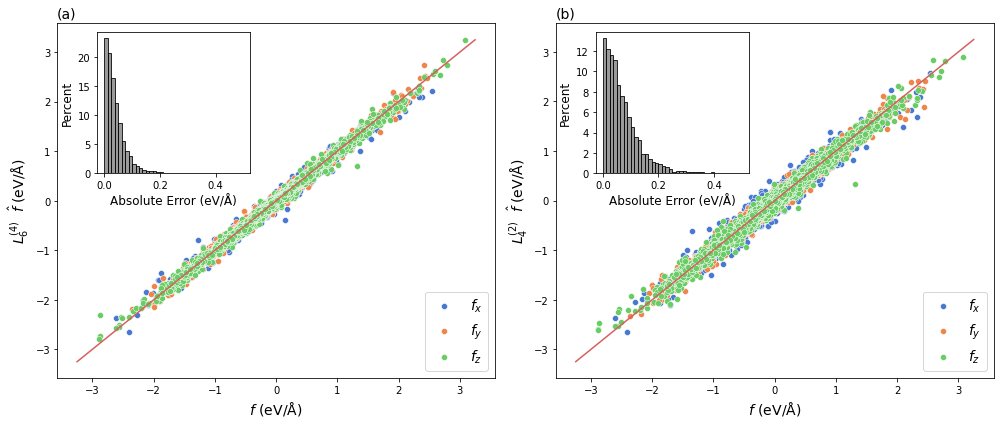

In [76]:
fig, axs = plt.subplots(ncols = 2, nrows = 1, figsize=(14, 6.0))

plot_calibration(preds['paths-exp4-coords2'], axs[1], [-3.25, 3.25], 40, (0,0.5), (0, 0.09, 1, 1), 4)
plot_calibration(preds['paths-exp6-coords4'], axs[0], [-3.25, 3.25], 40, (0,0.5), (0, 0.09, 1, 1), 4)
axs[0].set_title('(a)', loc = 'left', fontsize = 14)
axs[1].set_title('(b)', loc = 'left', fontsize = 14)
axs[0].set_ylabel(r'$L^{(4)}_6\ \ \hat{f}$ (eV/Å)', fontsize = 14)
axs[1].set_ylabel(r'$L^{(2)}_4\ \ \hat{f}$ (eV/Å)', fontsize = 14)
plt.tight_layout()
plt.savefig('figures/MO-calibrations.pdf', bbox_inches='tight')
plt.savefig('figures/MO-calibrations.svg', bbox_inches='tight')
plt.savefig('figures/MO-calibrations.png', bbox_inches='tight', dpi = 200)


Text(0, 0.5, '$\\hat{f}$ (eV/Å)')

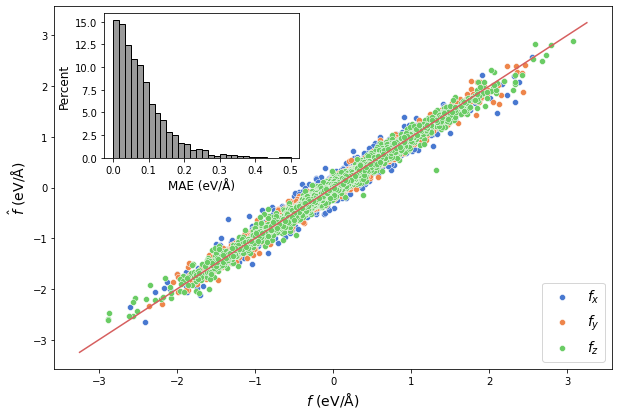

In [23]:
df_pred = preds['paths-exp4-coords2']

fig, axs = plt.subplots(ncols = 1, nrows = 1, figsize=(10, 6.67))

sns.scatterplot(data =  df_pred.loc['test'], x = 'x', y = 'x_hat', ax = axs, color = pal[0], label = r'$f_x$')
sns.scatterplot(data =  df_pred.loc['test'], x = 'y', y = 'y_hat', ax = axs, color = pal[1], label = r'$f_y$')
sns.scatterplot(data =  df_pred.loc['test'], x = 'z', y = 'z_hat', ax = axs, color = pal[2], label = r'$f_z$')

sns.lineplot(x = [-3.25, 3.25], y =  [-3.25, 3.25], color = pal[3], ax = axs)

axins = inset_axes(axs, width="35%", height="40%", loc=2, bbox_to_anchor=(0, 0.12, 1, 1), bbox_transform=axs.transAxes, borderpad = 5)#,)

sns.histplot(data = (df_pred['f'] - df_pred['f_hat']).abs().loc['test'], ax = axins, stat = 'percent', bins = 30, binrange=(0,0.5), color = pal[7])
axins.set_xlabel('MAE (eV/Å)', fontsize = 12)
axins.set_ylabel('Percent', fontsize = 12)

axs.legend(loc = 4, fontsize = 14)
axs.set_xlabel(r'$f$ (eV/Å)', fontsize = 14)
axs.set_ylabel(r'$\hat{f}$ (eV/Å)', fontsize = 14)



Text(0, 0.5, '$\\hat{f}$ (eV/Å)')

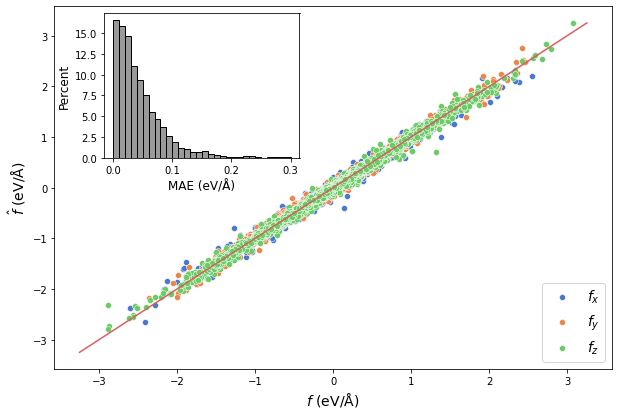

In [22]:
df_pred = preds['paths-exp6-coords4']

fig, axs = plt.subplots(ncols = 1, nrows = 1, figsize=(10, 6.67))

sns.scatterplot(data =  df_pred.loc['test'], x = 'x', y = 'x_hat', ax = axs, color = pal[0], label = r'$f_x$')
sns.scatterplot(data =  df_pred.loc['test'], x = 'y', y = 'y_hat', ax = axs, color = pal[1], label = r'$f_y$')
sns.scatterplot(data =  df_pred.loc['test'], x = 'z', y = 'z_hat', ax = axs, color = pal[2], label = r'$f_z$')

sns.lineplot(x = [-3.25, 3.25], y =  [-3.25, 3.25], color = pal[3], ax = axs)

axins = inset_axes(axs, width="35%", height="40%", loc=2, bbox_to_anchor=(0, 0.12, 1, 1), bbox_transform=axs.transAxes, borderpad = 5)#,)

sns.histplot(data = (df_pred['f'] - df_pred['f_hat']).abs().loc['test'], ax = axins, stat = 'percent', bins = 30, binrange=(0,0.3), color = pal[7])
axins.set_xlabel('MAE (eV/Å)', fontsize = 12)
axins.set_ylabel('Percent', fontsize = 12)

axs.legend(loc = 4, fontsize = 14)
axs.set_xlabel(r'$f$ (eV/Å)', fontsize = 14)
axs.set_ylabel(r'$\hat{f}$ (eV/Å)', fontsize = 14)


In [33]:
np.abs(f_train.reshape(-1, 3)).mean()

0.39541993

In [37]:
df.groupby(['Features', 'set'])['MAE Forces'].describe()

count      mean       std           min       25%  \
Features           set                                                          
paths-exp4-coords2 dev    10272.0  0.069393  0.062794  1.773238e-06  0.024518   
                   test   10272.0  0.069667  0.064428  9.775162e-06  0.024545   
                   train  61920.0  0.064591  0.055749  7.450581e-09  0.023868   
paths-exp6-coords4 dev    10272.0  0.039928  0.041768  1.116097e-05  0.013533   
                   test   10272.0  0.039899  0.040088  2.250075e-06  0.013446   
                   train  61920.0  0.030194  0.024950  1.769513e-07  0.011425   

                               50%       75%       max  
Features           set                                  
paths-exp4-coords2 dev    0.052877  0.094226  0.604099  
                   test   0.052771  0.095684  0.973093  
                   train  0.050619  0.089562  0.724017  
paths-exp6-coords4 dev    0.028878  0.052903  0.700010  
                   test   0.029126  0.053492  0.613807  
                   train  0.024449  0.042626  0.360697

In [11]:
all_models = [x.split('--')[0].split('/')[-1] for x in glob.glob('./results/*') if '16_32tanh' in x]

In [12]:
df, labels_list, preds_vector, preds, shapes = get_vectors(all_models)

paths-exp2-coords0 (20640, 7)
cycles-exp2-coords0 (20640, 7)
cycles-exp1-coords1 (20640, 25)
paths-exp4-coords0 (20640, 49)
paths-exp6-coords0 (20640, 373)
cycles-exp8-coords0 (20640, 31)
paths-exp8-coords0 (20640, 3055)
paths-exp10-coords0 (20640, 26491)
cycles-exp1-coords2 (20640, 65)
cycles-exp1-coords3 (20640, 353)
cycles-exp1-coords4 (20640, 873)
paths-exp2-coords1 (20640, 31)
cycles-exp2-coords1 (20640, 31)
paths-exp6-coords1 (20640, 397)
cycles-exp8-coords1 (20640, 55)
paths-exp10-coords1 (20640, 26515)
cycles-exp2-coords4 (20640, 879)
cycles-exp8-coords4 (20640, 903)
cycles-exp2-coords3 (20640, 359)
paths-exp6-coords4 (20640, 1245)
paths-exp4-coords1 (20640, 73)
paths-exp6-coords3 (20640, 725)
paths-exp2-coords2 (20640, 71)
paths-exp6-coords2 (20640, 437)
paths-exp2-coords4 (20640, 879)
paths-exp2-coords3 (20640, 359)
cycles-exp8-coords3 (20640, 383)
paths-exp8-coords1 (20640, 3079)
paths-exp8-coords2 (20640, 3119)
paths-exp4-coords2 (20640, 113)
paths-exp4-coords3 (20640, 401)

In [13]:
all_models

['paths-exp2-coords0',
 'cycles-exp2-coords0',
 'cycles-exp1-coords1',
 'paths-exp4-coords0',
 'paths-exp6-coords0',
 'cycles-exp8-coords0',
 'paths-exp8-coords0',
 'paths-exp10-coords0',
 'cycles-exp1-coords2',
 'cycles-exp1-coords3',
 'cycles-exp1-coords4',
 'paths-exp2-coords1',
 'cycles-exp2-coords1',
 'paths-exp6-coords1',
 'cycles-exp8-coords1',
 'paths-exp10-coords1',
 'cycles-exp2-coords4',
 'cycles-exp8-coords4',
 'cycles-exp2-coords3',
 'paths-exp6-coords4',
 'paths-exp4-coords1',
 'paths-exp6-coords3',
 'paths-exp2-coords2',
 'paths-exp6-coords2',
 'paths-exp2-coords4',
 'paths-exp2-coords3',
 'cycles-exp8-coords3',
 'paths-exp8-coords1',
 'paths-exp8-coords2',
 'paths-exp4-coords2',
 'paths-exp4-coords3',
 'paths-exp8-coords3',
 'paths-exp4-coords4',
 'cycles-exp2-coords2',
 'paths-exp8-coords4',
 'cycles-exp8-coords2']

In [14]:
df_shapes = pd.DataFrame(shapes).T
df_shapes[1].to_csv('shapes.csv')

In [21]:
df_all = df.groupby(['Features', 'set'])['MAE Forces'].describe()
df_all.to_csv('errors.csv')

In [22]:
df_all.loc['paths-exp']

count      mean       std           min  \
Features            set                                                
cycles-exp1-coords1 dev    10272.0  0.103078  0.245173  1.041889e-10   
                    test   10272.0  0.104933  0.274756  5.730172e-11   
                    train  61920.0  0.096203  0.230621  5.631176e-12   
cycles-exp1-coords2 dev    10272.0  0.027298  0.070993  5.190787e-11   
                    test   10272.0  0.026847  0.061453  6.571099e-11   
...                            ...       ...       ...           ...   
paths-exp8-coords3  test   10272.0  0.018151  0.076288  4.617107e-11   
                    train  61920.0  0.005190  0.009189  7.301505e-13   
paths-exp8-coords4  dev    10272.0  0.012247  0.046720  3.342748e-11   
                    test   10272.0  0.012787  0.046465  7.517542e-12   
                    train  61920.0  0.003917  0.006798  1.765788e-11   

                                25%       50%       75%       max  
Features            set                                            
cycles-exp1-coords1 dev    0.003617  0.018699  0.082361  3.978204  
                    test   0.003447  0.017708  0.078642  6.625381  
                    train  0.003296  0.017441  0.078017  5.700690  
cycles-exp1-coords2 dev    0.001409  0.007009  0.024815  3.488155  
                    test   0.001404  0.006493  0.024215  1.358267  
...                             ...       ...       ...       ...  
paths-exp8-coords3  test   0.000660  0.003167  0.011687  3.469755  
                    train  0.000423  0.001968  0.006053  0.275361  
paths-exp8-coords4  dev    0.000502  0.002379  0.008601  2.578836  
                    test   0.000509  0.002405  0.008596  1.680165  
                    train  0.000336  0.001507  0.004633  0.148102  

[108 rows x 8 columns]